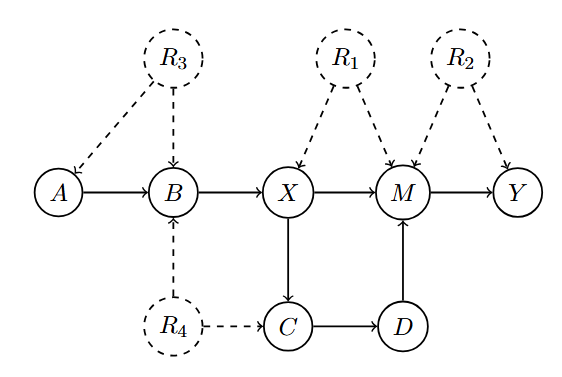

$\theta = P(Y|do(x, m))$ 

$pot(D|do(c))=0$

In [7]:
"""
True potency computation for a complex hidden-variable DAG (Figure 3)

Goal:
  Compute the *true potency* of an experiment a = P(D=1 | do(C=1)) for a target query θ
  by solving the (multi)linear canonical-response / response-mixture program twice:

    (1) Base program 𝒫_∅ (observational constraints only)  -> bounds [L_∅, U_∅], width W_∅
    (2) Program 𝒫_a (observational constraints + experiment fixed to p_a^true) -> [L_a, U_a], width W_a(p_a^true)

  True potency (Definition "True Potency" in the draft):
      pot_true(a) := W_∅ - W_a(p_a^true)

Notes:
  • Although the general Duarte et al. construction yields polynomial programs, in the *finite discrete SCM* setting
    with deterministic structural equations and mixture weights as decision variables, all constraints/objectives are
    *linear in the mixture weights q*. This is a degree-1 (multi)linear special case, so an LP solver returns the
    exact global optima.
  • The code below uses SciPy HiGHS (linprog) for the LP solves.

Paper notation alignment:
  • Observed variables: 𝑽 = {A, B, X, C, D, M, Y}, all binary.
  • Hidden structure is represented via *response-type / exogenous configurations*; decision variables are q.
    (The draft notes a later renaming: q corresponds to P(𝑹) / mixture weights over response-types.)
  • Observational data are treated as ground-truth probabilities P(𝒗) for all 𝒗 ∈ supp(𝑽) (here: estimated by simulation).
  • Experiment a contributes an equality constraint f_a(q) = p_a, here fixed to p_a^true.
"""

import itertools
import random
from dataclasses import dataclass

import numpy as np
from scipy.optimize import linprog


# =============================================================================
# 1) SCM definition consistent with Figure 3 (binary variables + latent confounding)
# =============================================================================

@dataclass
class SCMParams:
    """
    Parameters controlling the SCM's exogenous (latent) Bernoulli noise terms.

    The SCM is binary throughout; all variables take values in {0,1}.
    Each exogenous variable is sampled independently with the probability given below.

    The intent is to instantiate a *single ground-truth SCM* consistent with the DAG structure.
    Observational and interventional distributions are then generated by forward simulation.
    """
    p_eA: float = 0.45  # noise for A (A is a root node)
    p_U3: float = 0.35  # latent "confounder" affecting both A and B
    p_eB: float = 0.25  # additional noise for B
    p_U4: float = 0.40  # latent "confounder" affecting both B and C (via C's equation)
    p_U1: float = 0.30  # latent "confounder" affecting both X and M
    p_eD: float = 0.20  # noise for D
    p_U2: float = 0.55  # latent "confounder" affecting both M and Y
    p_eY: float = 0.15  # additional noise for Y


def bern(p: float, rng: random.Random) -> int:
    """Sample a Bernoulli(p) random variable in {0,1}."""
    return 1 if rng.random() < p else 0


def scm_forward(u: dict, do: dict | None = None) -> dict:
    """
    Forward-simulate the SCM once (one unit).

    Inputs:
      u: a single exogenous configuration (latent variables), e.g.
         u = {eA,U3,eB,U4,U1,eD,U2,eY} with each entry ∈ {0,1}
      do: an intervention dict encoding do(·), e.g. {"C":1} or {"X":1,"M":1}.
          For a node V, if V ∈ do, then V is set to do[V] and its structural equation is bypassed.

    Outputs:
      A dict of observed values (A,B,X,C,D,M,Y).

    Structural equations (all XOR / mod-2, purely for concreteness):
      A := eA                                     (root)
      B := A ⊕ U3 ⊕ eB                            (A -> B, plus latent influence U3)
      X := B ⊕ U1                                 (B -> X, plus latent influence U1)
      C := X ⊕ U4                                 (X -> C, plus latent influence U4)
      D := C ⊕ eD                                 (C -> D, plus noise eD)
      M := X ⊕ D ⊕ U1 ⊕ U2                        (X -> M, D -> M, plus latent U1,U2)
      Y := M ⊕ U2 ⊕ eY                            (M -> Y, plus latent U2 and noise eY)

    This SCM respects the directed edges:
      A->B->X->M->Y, X->C->D->M, and includes latent couplings consistent with dashed edges.
    """
    do = do or {}

    # A is a root: either intervened on, or equals its exogenous noise eA.
    A = do.get("A", u["eA"])

    # B depends on A, plus latent U3 and idiosyncratic noise eB.
    B = do.get("B", A ^ u["U3"] ^ u["eB"])

    # X depends on B and latent U1.
    X = do.get("X", B ^ u["U1"])

    # C depends on X and latent U4 (creating dependence between B and C through U4).
    C = do.get("C", X ^ u["U4"])

    # D depends on C and noise eD.
    D = do.get("D", C ^ u["eD"])

    # M depends on X, D, and latent U1, U2 (capturing the dashed edges to X/M and M/Y).
    M = do.get("M", X ^ D ^ u["U1"] ^ u["U2"])

    # Y depends on M, latent U2, and noise eY.
    Y = do.get("Y", M ^ u["U2"] ^ u["eY"])

    return {"A": A, "B": B, "X": X, "C": C, "D": D, "M": M, "Y": Y}


def sample_exogenous(params: SCMParams, rng: random.Random) -> dict:
    """
    Sample one exogenous configuration u.

    In the canonical-response view:
      • Each exogenous configuration corresponds to a particular response-type configuration.
      • The decision variables q will represent a distribution over these configurations.
    """
    return {
        "eA": bern(params.p_eA, rng),
        "U3": bern(params.p_U3, rng),
        "eB": bern(params.p_eB, rng),
        "U4": bern(params.p_U4, rng),
        "U1": bern(params.p_U1, rng),
        "eD": bern(params.p_eD, rng),
        "U2": bern(params.p_U2, rng),
        "eY": bern(params.p_eY, rng),
    }


# =============================================================================
# 2) Generate an example "ground truth" observational distribution P(V)
#    and the ground-truth experimental outcome p_a^true
# =============================================================================

def empirical_distribution(params: SCMParams, n: int = 200_000, seed: int = 0):
    """
    Simulate the SCM to obtain:

      • An empirical approximation to the observational distribution P(V),
        where V = (A,B,X,C,D,M,Y) and each is binary.

      • The ground-truth interventional experiment outcome:
            p_a^true = P(D=1 | do(C=1))

      • A concrete target query value θ_true for demonstration:
            θ_true = P(Y=1 | do(X=1, M=1))

    In the paper:
      • Observational distribution is treated as known probabilities P(v).
      • True potency fixes the experimental parameter to its ground-truth value p_a^true.
    """
    rng = random.Random(seed)

    # Enumerate all 2^7 observational configurations v ∈ supp(V)
    # in the fixed variable order (A,B,X,C,D,M,Y).
    counts = {v: 0 for v in itertools.product([0, 1], repeat=7)}

    count_p = 0        # counts D under do(C=1)
    count_theta = 0    # counts Y under do(X=1,M=1)

    for _ in range(n):
        u = sample_exogenous(params, rng)

        # observational draw
        obs = scm_forward(u, do={})
        v = (obs["A"], obs["B"], obs["X"], obs["C"], obs["D"], obs["M"], obs["Y"])
        counts[v] += 1

        # experiment a: do(C=1) and observe D
        count_p += scm_forward(u, do={"C": 1})["D"]

        # target query θ example: do(X=1,M=1) and observe Y
        count_theta += scm_forward(u, do={"X": 1, "M": 1})["Y"]

    P_hat = {v: c / n for v, c in counts.items()}
    p_true = count_p / n
    theta_true = count_theta / n
    return P_hat, p_true, theta_true


params = SCMParams()
P_hat, p_true, theta_true = empirical_distribution(params, n=200_000, seed=42)


# =============================================================================
# 3) Canonical-response / mixture program over q
# =============================================================================

"""
Decision variables q:

Instead of explicitly enumerating high-cardinality latent variables, the canonical approach enumerates
a finite set of response types (or, equivalently here, exogenous configurations) that fully determine
the observed variables under any intervention.

Let Ω be the set of all exogenous configurations (here 2^8 = 256 states).
Define decision variables:
    q_ω = P(ω)   for ω ∈ Ω
These q_ω play the role of P(R=r) / mixture weights in the draft.

Given deterministic SCM equations, any interventional or observational probability is a *linear* function of q:
    P(v)        = sum_{ω: g_obs(ω) = v} q_ω
    P(D=1|do(C=1)) = sum_{ω} q_ω * I[D_do(C=1)(ω)=1]
    θ(q)        = sum_{ω} q_ω * I[target event holds under intervention](ω)

Thus, solving for sharp bounds is an LP.
"""

# Enumerate all exogenous bits; Ω = {0,1}^8.
exo_names = ["eA", "U3", "eB", "U4", "U1", "eD", "U2", "eY"]
exo_states = list(itertools.product([0, 1], repeat=len(exo_names)))
n_q = len(exo_states)  # 256 decision variables

# Precompute (deterministic) mappings induced by each exogenous configuration:
#  • observational v(ω)
#  • D_do(C=1)(ω)
#  • Y_do(X=1,M=1)(ω)   (used for θ in this example)
obs_map = []
doC1_map_D = []
doXM_map_Y = []
for state in exo_states:
    u = dict(zip(exo_names, state))

    obs = scm_forward(u, do={})
    obs_tuple = (obs["A"], obs["B"], obs["X"], obs["C"], obs["D"], obs["M"], obs["Y"])
    obs_map.append(obs_tuple)

    doC1_map_D.append(scm_forward(u, do={"C": 1})["D"])
    doXM_map_Y.append(scm_forward(u, do={"X": 1, "M": 1})["Y"])


# =============================================================================
# 4) Observational constraints f_∅(q) = b_∅ with slack
# =============================================================================

"""
Base program 𝒫_∅ enforces that q reproduces the observational distribution P(V).

Exact equality constraints would be:
    For all v ∈ supp(V):
        sum_{ω: obs_map(ω)=v} q_ω = P_hat(v)

In practice (finite simulation, measurement error, mild assumption violations),
it is useful to allow slack ε_obs:
    | sum_{ω: obs_map(ω)=v} q_ω - P_hat(v) | ≤ ε_obs

This converts each equality to two inequalities:
    sum(...) ≤ P_hat(v) + ε_obs
   -sum(...) ≤ -P_hat(v) + ε_obs
"""

eps_obs = 2e-3  # slack on each observational cell probability

v_states = list(itertools.product([0, 1], repeat=7))  # 128 values for v=(A,B,X,C,D,M,Y)

A_ub = []
b_ub = []
for v in v_states:
    # row_v selects exactly those ω that generate v observationally
    idxs = [i for i, t in enumerate(obs_map) if t == v]
    row = np.zeros(n_q)
    row[idxs] = 1.0

    # sum row*q <= P_hat(v) + eps_obs
    A_ub.append(row)
    b_ub.append(P_hat[v] + eps_obs)

    # -sum row*q <= -P_hat(v) + eps_obs    i.e. sum row*q >= P_hat(v) - eps_obs
    A_ub.append(-row)
    b_ub.append(-P_hat[v] + eps_obs)

A_ub = np.array(A_ub)
b_ub = np.array(b_ub)

# Simplex constraints: q ≥ 0 and sum q = 1
A_eq = np.array([np.ones(n_q)])
b_eq = np.array([1.0])
bounds = [(0.0, 1.0)] * n_q


# =============================================================================
# 5) Add the experimental constraint f_a(q) = p_a^true (True Potency)
# =============================================================================

"""
Experiment a in the paper contributes an equality constraint:
    f_a(q) = p_a

For True Potency, p_a is fixed to the *ground-truth* value p_a^true obtained by SCM simulation:
    p_a^true = P(D=1 | do(C=1))

Under the mixture view:
    f_a(q) = sum_{ω} q_ω * I[D_do(C=1)(ω)=1]

As above, allow a tiny tolerance ε_exp:
    | f_a(q) - p_a^true | ≤ ε_exp
"""

def solve_bounds(add_experiment_constraint: bool, eps_exp: float = 1e-6):
    """
    Solve for sharp bounds on θ under:
      • base observational constraints (always)
      • optionally the experiment constraint f_a(q) = p_a^true

    Returns:
      (L, U) where:
        L = min θ(q)
        U = max θ(q)
    """
    A_ub2 = A_ub.copy()
    b_ub2 = b_ub.copy()

    if add_experiment_constraint:
        # f_a(q) = sum q_ω * I[D_do(C=1)(ω)=1]
        row = np.array(doC1_map_D, dtype=float)  # indicators in {0,1} per ω

        A_ub2 = np.vstack([A_ub2, row, -row])
        b_ub2 = np.concatenate([b_ub2, [p_true + eps_exp, -p_true + eps_exp]])

    # Target query θ(q) for demonstration:
    #   θ = P(Y=1 | do(X=1, M=1)) = sum_{ω} q_ω * I[Y_do(X=1,M=1)(ω)=1]
    c = np.array(doXM_map_Y, dtype=float)

    # Minimize θ:  min c^T q
    res_min = linprog(
        c=c, A_ub=A_ub2, b_ub=b_ub2, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs"
    )

    # Maximize θ:  max c^T q  <=> min (-c)^T q
    res_max = linprog(
        c=-c, A_ub=A_ub2, b_ub=b_ub2, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs"
    )

    if not (res_min.success and res_max.success):
        raise RuntimeError(
            f"LP failed: min_success={res_min.success}, max_success={res_max.success}\n"
            f"min_msg={res_min.message}\nmax_msg={res_max.message}"
        )

    L = res_min.fun
    U = -res_max.fun
    return L, U


# =============================================================================
# 6) Compute widths and True Potency
# =============================================================================

# Base bounds under 𝒫_∅
L0, U0 = solve_bounds(add_experiment_constraint=False)
W0 = U0 - L0

# Bounds under 𝒫_a with p_a fixed to p_a^true
L1, U1 = solve_bounds(add_experiment_constraint=True)
W1 = U1 - L1

# True potency (Definition in the draft)
pot_true = W0 - W1

print("Ground-truth experiment outcome p_a^true = P(D=1 | do(C=1)):", p_true)
print("Ground-truth θ_true = P(Y=1 | do(X=1,M=1)):", theta_true)
print("Base bounds [L_∅, U_∅] =", (L0, U0), "width W_∅ =", W0)
print("With experiment [L_a, U_a] =", (L1, U1), "width W_a(p_a^true) =", W1)
print("True potency pot_true(a) = W_∅ - W_a(p_a^true) =", pot_true)


Ground-truth experiment outcome p_a^true = P(D=1 | do(C=1)): 0.800575
Ground-truth θ_true = P(Y=1 | do(X=1,M=1)): 0.464655
Base bounds [L_∅, U_∅] = (0.3533450000000002, 0.5721400000000001) width W_∅ = 0.2187949999999999
With experiment [L_a, U_a] = (0.3533450000000002, 0.5721400000000001) width W_a(p_a^true) = 0.2187949999999999
True potency pot_true(a) = W_∅ - W_a(p_a^true) = 0.0


### Sanity Check
We calculate $pot(Y=1|do(M=1))$ which we expect to be greater than zero!

In [8]:
import itertools
import random
from dataclasses import dataclass

import numpy as np
from scipy.optimize import linprog

# =============================================================================
# 1) SCM definition (binary) consistent with the complex DAG (Figure 3)
# =============================================================================

@dataclass
class SCMParams:
    # Exogenous Bernoulli probabilities (all independent).
    p_eA: float = 0.45
    p_U3: float = 0.35   # latent link between A and B
    p_eB: float = 0.25
    p_U4: float = 0.40   # latent link between B and C (via C's equation)
    p_U1: float = 0.30   # latent link between X and M
    p_eD: float = 0.20
    p_U2: float = 0.55   # latent link between M and Y
    p_eY: float = 0.15

def bern(p: float, rng: random.Random) -> int:
    """Bernoulli(p) sample in {0,1}."""
    return 1 if rng.random() < p else 0

def scm_forward(u: dict, do: dict | None = None) -> dict:
    """
    One forward pass through the SCM, optionally under an intervention do(·).

    Observed variables (all binary): V = (A,B,X,C,D,M,Y).

    Structural equations (XOR/mod-2, chosen for concreteness):
      A := eA
      B := A ⊕ U3 ⊕ eB
      X := B ⊕ U1
      C := X ⊕ U4
      D := C ⊕ eD
      M := X ⊕ D ⊕ U1 ⊕ U2
      Y := M ⊕ U2 ⊕ eY

    Interventions:
      If a node V appears in do, its structural equation is bypassed and V is set to do[V].
    """
    do = do or {}
    A = do.get("A", u["eA"])
    B = do.get("B", A ^ u["U3"] ^ u["eB"])
    X = do.get("X", B ^ u["U1"])
    C = do.get("C", X ^ u["U4"])
    D = do.get("D", C ^ u["eD"])
    M = do.get("M", X ^ D ^ u["U1"] ^ u["U2"])
    Y = do.get("Y", M ^ u["U2"] ^ u["eY"])
    return {"A": A, "B": B, "X": X, "C": C, "D": D, "M": M, "Y": Y}

def sample_exogenous(params: SCMParams, rng: random.Random) -> dict:
    """Sample one exogenous configuration u."""
    return {
        "eA": bern(params.p_eA, rng),
        "U3": bern(params.p_U3, rng),
        "eB": bern(params.p_eB, rng),
        "U4": bern(params.p_U4, rng),
        "U1": bern(params.p_U1, rng),
        "eD": bern(params.p_eD, rng),
        "U2": bern(params.p_U2, rng),
        "eY": bern(params.p_eY, rng),
    }

# =============================================================================
# 2) Simulate an example observational distribution P(V) and true experiment outcomes
# =============================================================================

def empirical_distribution(params: SCMParams, n: int = 200_000, seed: int = 42):
    """
    Simulate the SCM to get:
      • P_hat(v) ≈ P(V=v) for all v ∈ supp(V) (V has 2^7 states),
      • pD_true = P(D=1 | do(C=1))  (the "zero potency" experiment in the text),
      • pY_true = P(Y=1 | do(M=1))  (sanity-check experiment expected to shrink θ-bounds),
      • theta_true = P(Y=1 | do(X=1,M=1)) (example θ used as the bounding target below).
    """
    rng = random.Random(seed)

    # Observational distribution over v=(A,B,X,C,D,M,Y)
    counts = {v: 0 for v in itertools.product([0, 1], repeat=7)}

    count_pD = 0      # for pD_true = P(D=1 | do(C=1))
    count_pY = 0      # for pY_true = P(Y=1 | do(M=1))
    count_theta = 0   # for theta_true = P(Y=1 | do(X=1,M=1))

    for _ in range(n):
        u = sample_exogenous(params, rng)

        # Observational sample
        obs = scm_forward(u, do={})
        v = (obs["A"], obs["B"], obs["X"], obs["C"], obs["D"], obs["M"], obs["Y"])
        counts[v] += 1

        # True experimental outcomes (ground truth, used for "true potency")
        count_pD += scm_forward(u, do={"C": 1})["D"]
        count_pY += scm_forward(u, do={"M": 1})["Y"]

        # Example θ value under do(X=1,M=1)
        count_theta += scm_forward(u, do={"X": 1, "M": 1})["Y"]

    P_hat = {v: c / n for v, c in counts.items()}
    pD_true = count_pD / n
    pY_true = count_pY / n
    theta_true = count_theta / n
    return P_hat, pD_true, pY_true, theta_true

params = SCMParams()
P_hat, pD_true, pY_true, theta_true = empirical_distribution(params)

# =============================================================================
# 3) Canonical-response / mixture program over decision variables q
# =============================================================================

"""
Decision variables:
  Ω = set of all exogenous configurations (here 2^8 = 256).
  q_ω = P(ω), with q in the probability simplex.

Because the SCM is deterministic given ω, any event probability is linear in q:
  P(v) = Σ_{ω: g_obs(ω)=v} q_ω
and similarly for interventional outcomes.
"""

exo_names = ["eA", "U3", "eB", "U4", "U1", "eD", "U2", "eY"]
exo_states = list(itertools.product([0, 1], repeat=len(exo_names)))  # 256 states
n_q = len(exo_states)

# Precompute mappings induced by each ω:
#  • obs_map[ω]   = observational v=(A,B,X,C,D,M,Y)
#  • doC1_map_D[ω]= D under do(C=1) (used in experiment #2)
#  • doM1_map_Y[ω]= Y under do(M=1) (used in experiment #3)
#  • doXM_map_Y[ω]= Y under do(X=1,M=1) (this is θ)
obs_map = []
doC1_map_D = []
doM1_map_Y = []
doXM_map_Y = []

for state in exo_states:
    u = dict(zip(exo_names, state))

    obs = scm_forward(u, do={})
    obs_map.append((obs["A"], obs["B"], obs["X"], obs["C"], obs["D"], obs["M"], obs["Y"]))

    doC1_map_D.append(scm_forward(u, do={"C": 1})["D"])
    doM1_map_Y.append(scm_forward(u, do={"M": 1})["Y"])
    doXM_map_Y.append(scm_forward(u, do={"X": 1, "M": 1})["Y"])

# =============================================================================
# 4) Observational constraints with slack (compatibility / sampling noise)
# =============================================================================

"""
Observational constraints:
  For each v ∈ supp(V):
    Σ_{ω: obs_map(ω)=v} q_ω = P_hat(v)

To allow mild incompatibility / finite-sample noise, impose:
  | Σ(...) - P_hat(v) | ≤ eps_obs
"""

eps_obs = 2e-3
v_states = list(itertools.product([0, 1], repeat=7))  # 128 v-states

A_ub = []
b_ub = []
for v in v_states:
    idxs = [i for i, t in enumerate(obs_map) if t == v]
    row = np.zeros(n_q)
    row[idxs] = 1.0

    # Σ row*q ≤ P_hat(v) + eps_obs
    A_ub.append(row)
    b_ub.append(P_hat[v] + eps_obs)

    # -Σ row*q ≤ -P_hat(v) + eps_obs  (equivalently Σ row*q ≥ P_hat(v) - eps_obs)
    A_ub.append(-row)
    b_ub.append(-P_hat[v] + eps_obs)

A_ub = np.array(A_ub)
b_ub = np.array(b_ub)

# Simplex constraints on q
A_eq = np.array([np.ones(n_q)])
b_eq = np.array([1.0])
bounds = [(0.0, 1.0)] * n_q

# =============================================================================
# 5) Solve sharp bounds for θ under exactly one (or no) experiment constraint
# =============================================================================

def solve_bounds(which_experiment: str | None, eps_exp: float = 1e-6):
    """
    Solve for sharp bounds [L, U] on θ(q) under:

      (1) which_experiment is None:
          Base program 𝒫_∅ (observational constraints only)

      (2) which_experiment == "D_doC":
          Program 𝒫_{a_D} with the single experiment constraint:
              P(D=1 | do(C=1)) = pD_true  (± eps_exp)

      (3) which_experiment == "Y_doM":
          Program 𝒫_{a_Y} with the single experiment constraint:
              P(Y=1 | do(M=1)) = pY_true  (± eps_exp)

    IMPORTANT:
      This function intentionally supports ONLY ONE experiment at a time.
      No code path constructs bounds under both experiments simultaneously.
    """
    A_ub2 = A_ub.copy()
    b_ub2 = b_ub.copy()

    # Add exactly one experimental equality (as a pair of inequalities with tolerance eps_exp)
    if which_experiment == "D_doC":
        # f_{a_D}(q) = Σ q_ω * I[D_do(C=1)(ω)=1] = pD_true
        row = np.array(doC1_map_D, dtype=float)
        A_ub2 = np.vstack([A_ub2, row, -row])
        b_ub2 = np.concatenate([b_ub2, [pD_true + eps_exp, -pD_true + eps_exp]])

    elif which_experiment == "Y_doM":
        # f_{a_Y}(q) = Σ q_ω * I[Y_do(M=1)(ω)=1] = pY_true
        row = np.array(doM1_map_Y, dtype=float)
        A_ub2 = np.vstack([A_ub2, row, -row])
        b_ub2 = np.concatenate([b_ub2, [pY_true + eps_exp, -pY_true + eps_exp]])

    elif which_experiment is None:
        pass
    else:
        raise ValueError("which_experiment must be one of: None, 'D_doC', 'Y_doM'")

    # Target query θ(q) = P(Y=1 | do(X=1,M=1)) = Σ q_ω * I[Y_do(X=1,M=1)(ω)=1]
    c = np.array(doXM_map_Y, dtype=float)

    # L = min θ(q)
    res_min = linprog(c=c, A_ub=A_ub2, b_ub=b_ub2, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

    # U = max θ(q) = - min (-θ(q))
    res_max = linprog(c=-c, A_ub=A_ub2, b_ub=b_ub2, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

    if not (res_min.success and res_max.success):
        raise RuntimeError(
            f"LP failed.\nmin: {res_min.success} {res_min.message}\nmax: {res_max.success} {res_max.message}"
        )

    L = res_min.fun
    U = -res_max.fun
    return L, U

# =============================================================================
# 6) Compute the three requested bound pairs (separate programs only)
# =============================================================================

# (1) Bounds under no experiment (observational only)
L0, U0 = solve_bounds(None)
W0 = U0 - L0

# (2) Bounds under experiment a_D: P(D=1 | do(C=1)) fixed to pD_true
L_D, U_D = solve_bounds("D_doC")
W_D = U_D - L_D

# (3) Bounds under experiment a_Y: P(Y=1 | do(M=1)) fixed to pY_true
L_Y, U_Y = solve_bounds("Y_doM")
W_Y = U_Y - L_Y

print("Ground-truth experiment outcomes:")
print("  pD_true = P(D=1 | do(C=1)) =", pD_true)
print("  pY_true = P(Y=1 | do(M=1)) =", pY_true)
print("Ground-truth θ_true = P(Y=1 | do(X=1,M=1)) =", theta_true)
print()

print("(1) Base (observational) bounds [L_∅, U_∅] =", (L0, U0), "width W_∅ =", W0)
print("(2) With a_D: P(D=1|do(C=1)) fixed     [L_D, U_D] =", (L_D, U_D), "width W_D =", W_D)
print("(3) With a_Y: P(Y=1|do(M=1)) fixed     [L_Y, U_Y] =", (L_Y, U_Y), "width W_Y =", W_Y)
print()

print("True potencies (relative to base):")
print("  pot_true(a_D) =", W0 - W_D)
print("  pot_true(a_Y) =", W0 - W_Y)


Ground-truth experiment outcomes:
  pD_true = P(D=1 | do(C=1)) = 0.800575
  pY_true = P(Y=1 | do(M=1)) = 0.464655
Ground-truth θ_true = P(Y=1 | do(X=1,M=1)) = 0.464655

(1) Base (observational) bounds [L_∅, U_∅] = (0.3533450000000002, 0.5721400000000001) width W_∅ = 0.2187949999999999
(2) With a_D: P(D=1|do(C=1)) fixed     [L_D, U_D] = (0.3533450000000002, 0.5721400000000001) width W_D = 0.2187949999999999
(3) With a_Y: P(Y=1|do(M=1)) fixed     [L_Y, U_Y] = (0.46465400000000007, 0.464656) width W_Y = 1.999999999946489e-06

True potencies (relative to base):
  pot_true(a_D) = 0.0
  pot_true(a_Y) = 0.21879299999999996


In [12]:
import itertools
import random
from dataclasses import dataclass

import numpy as np
from scipy.optimize import linprog

# =============================================================================
# 1) SCM definition (binary) consistent with the complex DAG (Figure 3)
# =============================================================================

@dataclass
class SCMParams:
    # Exogenous Bernoulli probabilities (all independent).
    p_eA: float = 0.45
    p_U3: float = 0.35   # latent link between A and B
    p_eB: float = 0.25
    p_U4: float = 0.40   # latent link between B and C (via C's equation)
    p_U1: float = 0.30   # latent link between X and M
    p_eD: float = 0.20
    p_U2: float = 0.55   # latent link between M and Y
    p_eY: float = 0.15

def bern(p: float, rng: random.Random) -> int:
    """Bernoulli(p) sample in {0,1}."""
    return 1 if rng.random() < p else 0

def scm_forward(u: dict, do: dict | None = None) -> dict:
    """
    One forward pass through the SCM, optionally under an intervention do(·).

    Observed variables (all binary): V = (A,B,X,C,D,M,Y).

    Structural equations (XOR/mod-2, chosen for concreteness):
      A := eA
      B := A ⊕ U3 ⊕ eB
      X := B ⊕ U1
      C := X ⊕ U4
      D := C ⊕ eD
      M := X ⊕ D ⊕ U1 ⊕ U2
      Y := M ⊕ U2 ⊕ eY

    Interventions:
      If a node V appears in do, its structural equation is bypassed and V is set to do[V].
    """
    do = do or {}
    A = do.get("A", u["eA"])
    B = do.get("B", A ^ u["U3"] ^ u["eB"])
    X = do.get("X", B ^ u["U1"])
    C = do.get("C", X ^ u["U4"])
    D = do.get("D", C ^ u["eD"])
    M = do.get("M", X ^ D ^ u["U1"] ^ u["U2"])
    Y = do.get("Y", M ^ u["U2"] ^ u["eY"])
    return {"A": A, "B": B, "X": X, "C": C, "D": D, "M": M, "Y": Y}

def sample_exogenous(params: SCMParams, rng: random.Random) -> dict:
    """Sample one exogenous configuration u."""
    return {
        "eA": bern(params.p_eA, rng),
        "U3": bern(params.p_U3, rng),
        "eB": bern(params.p_eB, rng),
        "U4": bern(params.p_U4, rng),
        "U1": bern(params.p_U1, rng),
        "eD": bern(params.p_eD, rng),
        "U2": bern(params.p_U2, rng),
        "eY": bern(params.p_eY, rng),
    }

# =============================================================================
# 2) Simulate an example observational distribution P(V) and true experiment outcomes
# =============================================================================

def empirical_distribution(params: SCMParams, n: int = 200_000, seed: int = 42):
    """
    Simulate the SCM to get:
      • P_hat(v) ≈ P(V=v) for all v ∈ supp(V) (V has 2^7 states),
      • pD_true  = P(D=1 | do(C=1))                          (experiment #2),
      • pYM_true = P(Y=1, M=1 | do(X=1))                     (experiment #3),
      • theta_true = P(Y=1 | do(X=1,M=1)) (example θ used as the bounding target).
    """
    rng = random.Random(seed)

    # Observational distribution over v=(A,B,X,C,D,M,Y)
    counts = {v: 0 for v in itertools.product([0, 1], repeat=7)}

    count_pD = 0       # for pD_true = P(D=1 | do(C=1))
    count_pYM = 0      # for pYM_true = P(Y=1, M=1 | do(X=1))
    count_theta = 0    # for theta_true = P(Y=1 | do(X=1,M=1))

    for _ in range(n):
        u = sample_exogenous(params, rng)

        # Observational sample
        obs = scm_forward(u, do={})
        v = (obs["A"], obs["B"], obs["X"], obs["C"], obs["D"], obs["M"], obs["Y"])
        counts[v] += 1

        # True experimental outcomes (ground truth, used for "true potency")
        count_pD += scm_forward(u, do={"C": 1})["D"]

        inter_X1 = scm_forward(u, do={"X": 1})
        count_pYM += 1 if (inter_X1["Y"] == 1 and inter_X1["M"] == 1) else 0

        # Example θ value under do(X=1,M=1)
        count_theta += scm_forward(u, do={"X": 1, "M": 1})["Y"]

    P_hat = {v: c / n for v, c in counts.items()}
    pD_true = count_pD / n
    pYM_true = count_pYM / n
    theta_true = count_theta / n
    return P_hat, pD_true, pYM_true, theta_true

params = SCMParams()
P_hat, pD_true, pYM_true, theta_true = empirical_distribution(params)

# =============================================================================
# 3) Canonical-response / mixture program over decision variables q
# =============================================================================

exo_names = ["eA", "U3", "eB", "U4", "U1", "eD", "U2", "eY"]
exo_states = list(itertools.product([0, 1], repeat=len(exo_names)))  # 256 states
n_q = len(exo_states)

# Precompute mappings induced by each ω:
#  • obs_map[ω]       = observational v=(A,B,X,C,D,M,Y)
#  • doC1_map_D[ω]    = D under do(C=1)                    (experiment #2)
#  • doX1_map_YM[ω]   = 1{Y=1 and M=1} under do(X=1)       (experiment #3)
#  • doXM_map_Y[ω]    = Y under do(X=1,M=1)                (target θ)
obs_map = []
doC1_map_D = []
doX1_map_YM = []
doXM_map_Y = []

for state in exo_states:
    u = dict(zip(exo_names, state))

    obs = scm_forward(u, do={})
    obs_map.append((obs["A"], obs["B"], obs["X"], obs["C"], obs["D"], obs["M"], obs["Y"]))

    doC1_map_D.append(scm_forward(u, do={"C": 1})["D"])

    inter_X1 = scm_forward(u, do={"X": 1})
    doX1_map_YM.append(1 if (inter_X1["Y"] == 1 and inter_X1["M"] == 1) else 0)

    doXM_map_Y.append(scm_forward(u, do={"X": 1, "M": 1})["Y"])

# =============================================================================
# 4) Observational constraints with slack
# =============================================================================

eps_obs = 2e-3
v_states = list(itertools.product([0, 1], repeat=7))  # 128 v-states

A_ub = []
b_ub = []
for v in v_states:
    idxs = [i for i, t in enumerate(obs_map) if t == v]
    row = np.zeros(n_q)
    row[idxs] = 1.0

    A_ub.append(row)
    b_ub.append(P_hat[v] + eps_obs)

    A_ub.append(-row)
    b_ub.append(-P_hat[v] + eps_obs)

A_ub = np.array(A_ub)
b_ub = np.array(b_ub)

A_eq = np.array([np.ones(n_q)])
b_eq = np.array([1.0])
bounds = [(0.0, 1.0)] * n_q

# =============================================================================
# 5) Solve sharp bounds for θ under exactly one (or no) experiment constraint
# =============================================================================

def solve_bounds(which_experiment: str | None, eps_exp: float = 1e-6):
    """
    Solve for sharp bounds [L, U] on θ(q) under:

      (1) which_experiment is None:
          Base program 𝒫_∅ (observational constraints only)

      (2) which_experiment == "D_doC":
          Program 𝒫_{a_D} with the single experiment constraint:
              P(D=1 | do(C=1)) = pD_true  (± eps_exp)

      (3) which_experiment == "YM_doX":
          Program 𝒫_{a_YM} with the single experiment constraint:
              P(Y=1, M=1 | do(X=1)) = pYM_true  (± eps_exp)

    IMPORTANT:
      This function intentionally supports ONLY ONE experiment at a time.
    """
    A_ub2 = A_ub.copy()
    b_ub2 = b_ub.copy()

    if which_experiment == "D_doC":
        row = np.array(doC1_map_D, dtype=float)
        A_ub2 = np.vstack([A_ub2, row, -row])
        b_ub2 = np.concatenate([b_ub2, [pD_true + eps_exp, -pD_true + eps_exp]])

    elif which_experiment == "YM_doX":
        row = np.array(doX1_map_YM, dtype=float)
        A_ub2 = np.vstack([A_ub2, row, -row])
        b_ub2 = np.concatenate([b_ub2, [pYM_true + eps_exp, -pYM_true + eps_exp]])

    elif which_experiment is None:
        pass
    else:
        raise ValueError("which_experiment must be one of: None, 'D_doC', 'YM_doX'")

    # Target query θ(q) = P(Y=1 | do(X=1,M=1)) = Σ q_ω * I[Y_do(X=1,M=1)(ω)=1]
    c = np.array(doXM_map_Y, dtype=float)

    res_min = linprog(c=c, A_ub=A_ub2, b_ub=b_ub2, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    res_max = linprog(c=-c, A_ub=A_ub2, b_ub=b_ub2, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

    if not (res_min.success and res_max.success):
        raise RuntimeError(
            f"LP failed.\nmin: {res_min.success} {res_min.message}\nmax: {res_max.success} {res_max.message}"
        )

    L = res_min.fun
    U = -res_max.fun
    return L, U

# =============================================================================
# 6) Compute the three requested bound pairs (separate programs only)
# =============================================================================

# (1) Bounds under no experiment (observational only)
L0, U0 = solve_bounds(None)
W0 = U0 - L0

# (2) Bounds under experiment a_D: P(D=1 | do(C=1)) fixed to pD_true
L_D, U_D = solve_bounds("D_doC")
W_D = U_D - L_D

# (3) Bounds under experiment a_YM: P(Y=1,M=1 | do(X=1)) fixed to pYM_true
L_YM, U_YM = solve_bounds("YM_doX")
W_YM = U_YM - L_YM

print("Ground-truth experiment outcomes:")
print("  pD_true  = P(D=1 | do(C=1))              =", pD_true)
print("  pYM_true = P(Y=1, M=1 | do(X=1))         =", pYM_true)
print("Ground-truth θ_true = P(Y=1 | do(X=1,M=1)) =", theta_true)
print()

print("(1) Base (observational) bounds [L_∅, U_∅] =", (L0, U0), "width W_∅ =", W0)
print("(2) With a_D:  P(D=1|do(C=1)) fixed        [L_D, U_D] =", (L_D, U_D), "width W_D =", W_D)
print("(3) With a_YM: P(Y=1,M=1|do(X=1)) fixed    [L_YM, U_YM] =", (L_YM, U_YM), "width W_YM =", W_YM)
print()

print("True potencies (relative to base):")
print("  pot_true(a_D)  =", W0 - W_D)
print("  pot_true(a_YM) =", W0 - W_YM)


Ground-truth experiment outcomes:
  pD_true  = P(D=1 | do(C=1))              = 0.800575
  pYM_true = P(Y=1, M=1 | do(X=1))         = 0.226495
Ground-truth θ_true = P(Y=1 | do(X=1,M=1)) = 0.464655

(1) Base (observational) bounds [L_∅, U_∅] = (0.3533450000000002, 0.5721400000000001) width W_∅ = 0.2187949999999999
(2) With a_D:  P(D=1|do(C=1)) fixed        [L_D, U_D] = (0.3533450000000002, 0.5721400000000001) width W_D = 0.2187949999999999
(3) With a_YM: P(Y=1,M=1|do(X=1)) fixed    [L_YM, U_YM] = (0.40795400000000004, 0.528656) width W_YM = 0.12070199999999998

True potencies (relative to base):
  pot_true(a_D)  = 0.0
  pot_true(a_YM) = 0.09809299999999993
